In [1]:
import xarray
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from skimage.restoration import denoise_bilateral, denoise_wavelet

import prosail
# import Py6S

from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern

In [2]:
aerial_F = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_F.nc')
aerial_HSI = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_HDRF.nc')
aerial_LST = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_LST.nc')
field_data = pd.read_csv('data/SSC_SENSECOWG1/1_SSC_data/FieldData.csv')
field_data2 = pd.read_csv('data/SSC_SENSECOWG1/1_SSC_data/FieldData_hh.csv')

In [3]:
def stack(x):
    return np.atleast_2d(x.stack(pix=['row','col']).copy().values)

def preprocess_hsi(x, data_var='var_',
                   geometry_vars=[]):
    xnew=[]
    xnew.append(stack(x[data_var]))
    for v in geometry_vars:
        xnew.append(stack(x[v]))
    return np.concatenate(xnew).T

def to_xarray(x, shape=(100,100,5)):
    return xarray.DataArray(x.reshape(shape).T,
                         dims=['dim0','col','row'])

def get_pix_n(xs, ys):
    lookup = np.arange(10000).reshape((100,100))
    return lookup[ys, xs]

def get_window_n(xs, ys, k=[-1,0,1]):
    """same as get_pix_n but retrieves a windowed region around point
    """
    out = []
    for i in k:
        for j in k:
            out.append(get_pix_n(xs+i, ys+j))
    return np.concatenate(out)

# LAI


# Chlorophyll concentration

## PROSPECT model

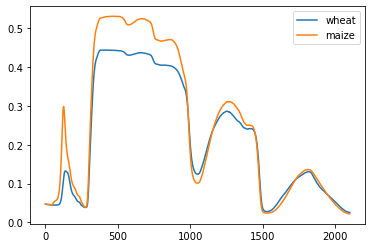

In [4]:
wheat = {
    'n': 1.5,
    'cab': 50,
    'car': 10,
    'cbrown': 0,
    'cw': .015,
    'cm': .009,
    'alpha': 52
}

maize = {
    'n': 2.0,
    'cab': 48.1,
    'car': 0,
    'cbrown': .08,
    'cw': .027,
    'cm': .0046,
    'alpha': 50
}
plt.plot(prosail.run_prospect(**wheat)[1], label='wheat')
plt.plot(prosail.run_prospect(**maize)[1], label='maize')
plt.legend()

In [5]:
import pymc3 as pm
import warnings

In [6]:
# plt.scatter(_observed_wavelengths, aerial_HSI['var_'].isel(col=41,row=83))

In [7]:
_observed_wavelengths = aerial_HSI['wvl_center'].values
# trim to VNIR only
observed_wavelengths = _observed_wavelengths#[:393]

def prospect_model(n, cab, cbrown, cw, cm):
    """Run the prospect model with truncated values
    
    Interpolate to observed wavelength after 
    """
        
    w,r, _ = prosail.run_prospect(n, cab, 0, cbrown, cw, cm)
    rho = np.interp(observed_wavelengths, w, r)
    rho[rho>1] = 1
    rho[rho<0] = 0
    return np.nan_to_num(rho)

def prosail_model(cab, cbrown, lai, cw):
    """Run the prospect model with truncated values
    
    Interpolate to observed wavelength after 
    """
    def trunc(x, _min=.0001, _max=1000000):
        if x < _min:
            return _min
        if x > _max:
            return _max
        
        return float(x)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            _rho = prosail.run_prosail(n=1.5, cab=trunc(cab), car=10,
                                       cbrown=trunc(cbrown, 0, 1), cw=trunc(cw),
                                       cm=.009, lai=trunc(lai, 1), lidfa=50, hspot=.2,
                                       tts=_tts, tto=_tto, psi=_psi, rsoil=.1, psoil=.5)
        except TypeError:
            return np.zeros_like(observed_wavelengths)
    
    w = np.arange(400,2501)
    
    rho = np.interp(observed_wavelengths, w, _rho)
    
    if (rho>2).any():
        return np.zeros_like(observed_wavelengths)
    
    if (rho<0).any():
        return np.zeros_like(observed_wavelengths)
    
    if np.isnan(rho).any():
        return np.zeros_like(observed_wavelengths)

    return rho

In [8]:
def n_prosail(cm):
    lsa = 1/cm/1000
    return (lsa * .9 + .025) / (lsa - .1)

In [9]:
import arviz as az
import theano.tensor as tt
from scipy.stats import mode

In [10]:
_tto = float(aerial_HSI.VZA.isel(col=10, row=51))
_psi = float(aerial_HSI.SVAA.isel(col=10, row=51))
_tts = 70.97
observed = aerial_HSI['var_'].isel(col=10,row=51).values#[:393]

In [787]:
with pm.Model() as m1:
    
    n_mu = pm.Uniform('n_mu', lower=.3, upper=1.5)
    n_sigma = pm.Uniform('n_sigma', .1,1)
    
    cab_mu = pm.Uniform('cab_mu', lower=13, upper=60)
    cab_sigma = pm.Uniform('cab_sigma', 2, 15)
    
    cbrown_mu = pm.Uniform('cbrown_mu', lower=0, upper=1)
    cbrown_sigma = pm.Uniform('cbrown_sigma', .1, .4)
    
    lai_mu = pm.Uniform('lai_mu', lower=.5, upper=6)
    lai_sigma = pm.Uniform('lai_sigma', 1, 2)
    
    cw_mu = pm.Uniform('cw_mu', lower=.001, upper=.035)
    cw_sigma = pm.Uniform('cw_sigma', lower=.0006, upper=.0009)
    
# #     cm_mu = pm.Uniform('cm_mu', lower=.001, upper=.035)
# #     cm_sigma = pm.HalfNormal('cm_sigma', .0008)

    
#     # lidfa_mu = pm.Uniform('lidfa_mu', lower=25, upper=78)
#     # lidfa_sigma = pm.HalfNormal('lidfa_sigma', 20)
    
#     # Normal
    n = pm.Normal('n', n_mu, n_sigma )
    cab = pm.Normal('cab', cab_mu, cab_sigma)
    cbrown = pm.Normal('cbrown', cbrown_mu, cbrown_sigma)
    lai = pm.Normal('lai', lai_mu, lai_sigma)
    cw = pm.Normal('cw', cw_mu, cw_sigma)
    
    # #Normal
    # n = pm.Normal('n', 1, 3)
    # cab = pm.Normal('cab', 50, 30)
    # cbrown = pm.Normal('cbrown', 0, .2)
    # lai = pm.Normal('lai', 3.5, 5)
    # cw = pm.Normal('cw', .015, .01)
    
    # cw = pm.Normal('cw', cw_mu, cw_sigma)
    # cm = pm.Normal('cm', cm_mu, cm_sigma)
    
    # lidfa = pm.Normal('lidfa', lidfa_mu, lidfa_sigma)
    
    # hspot = pm.Normal('hspot', .5, .4)
    # hspot = pm.Constant('hspot', 0)
    # tts = pm.Constant('tts', _tts)
    # tto = pm.Constant('tto', _tto)
    # psi = pm.Constant('psi', _psi)
    
    sim = pm.Simulator("sim",
                       prosail_model,
                       params=(cab, cbrown, lai, cw),
                       epsilon=.1,
                       observed=observed)
    
    trace_lv = pm.sample_smc(2500, kernel="ABC", parallel=True, chains=2, cores=2)
    idata_lv = az.from_pymc3(trace_lv)

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.018
Process ForkPoolWorker-579:
Process ForkPoolWorker-580:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[

array([[<AxesSubplot:ylabel='cbrown'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='lai'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='cab', ylabel='cw'>,
        <AxesSubplot:xlabel='cbrown'>, <AxesSubplot:xlabel='lai'>]],
      dtype=object)

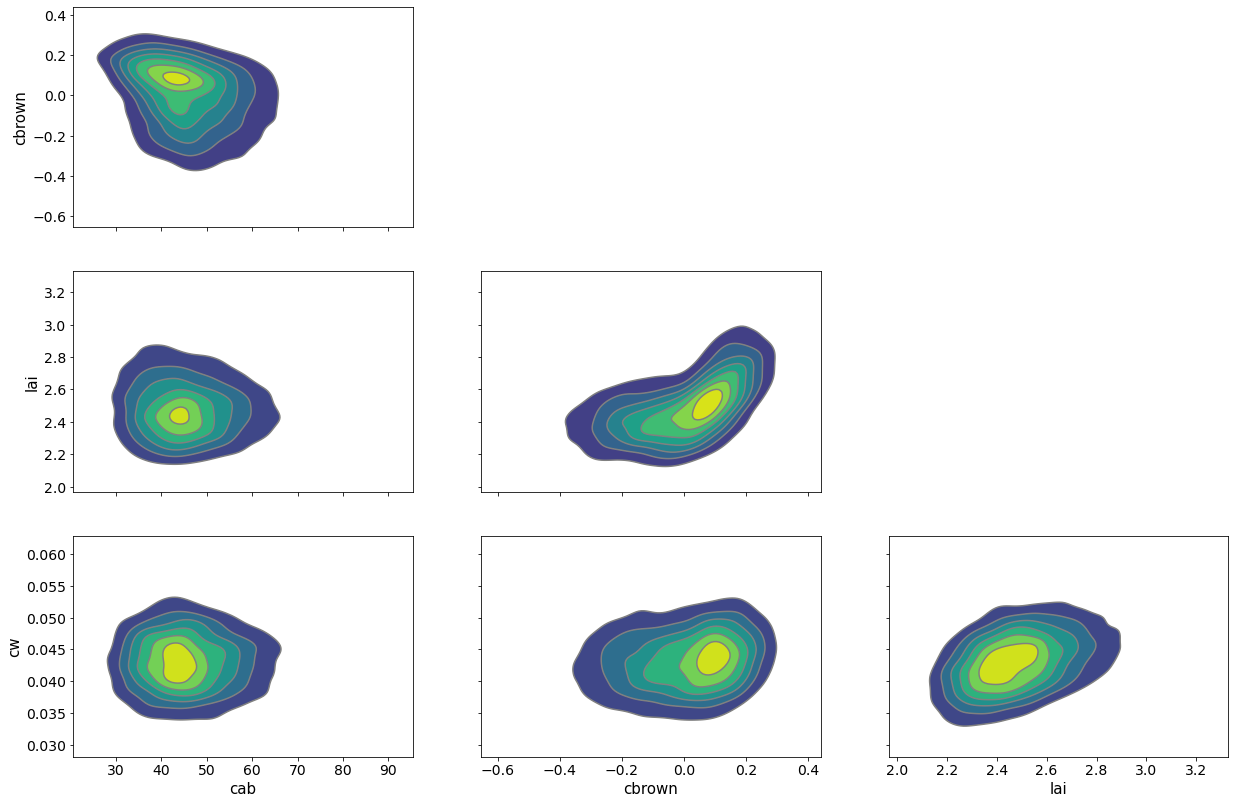

In [782]:
az.plot_pair(idata_lv, kind='kde')

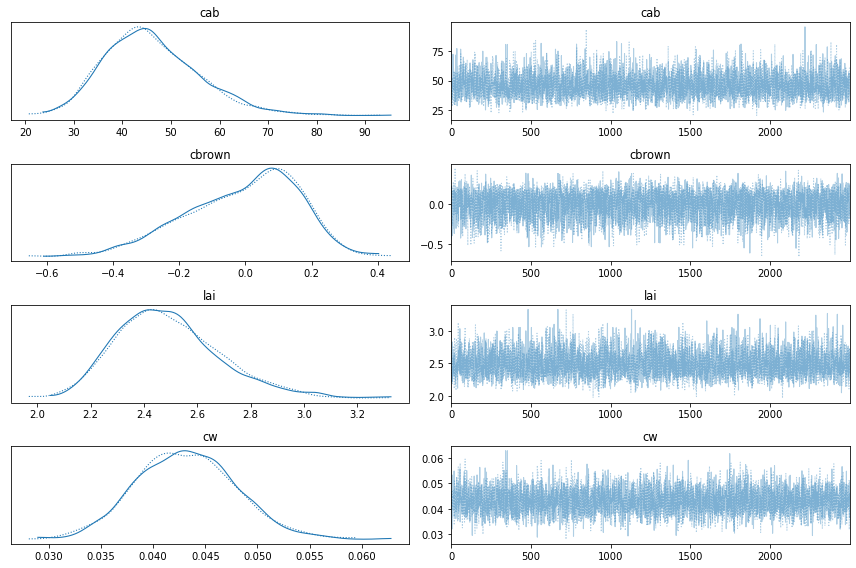

In [783]:
az.plot_trace(idata_lv, combined=False)
plt.tight_layout()

In [784]:
field_data.iloc[1]

PlotNum                               2
Xutm                           262731.5
Yutm                          4426210.5
Xpix                                 10
Ypix                                 51
Crop                              Wheat
LAI                            5.754653
Cab                           40.553934
Vcmax25_time       01-Jul-2019 10:25:11
Vcmax25                       19.444781
NPQ1_time          01-Jul-2019 08:55:40
NPQ1                           1.312276
NPQ2_time          01-Jul-2019 10:54:32
NPQ2                           1.609896
ceptometer_time    01-Jul-2019 13:09:23
PARin                       2220.429705
PARbottom                     11.136204
PARrefl_top                   67.610225
PARrefl_soil                   21.60395
aPAR                        2163.287226
faPAR                          0.974265
Name: 1, dtype: object

In [785]:
az.stats.summary(idata_lv)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cab,46.072,9.723,29.814,65.087,0.140,0.099,4823.0,5072.0,1.0
cbrown,-0.008,0.170,-0.342,0.266,0.002,0.002,4959.0,4141.0,1.0
lai,2.491,0.194,2.174,2.889,0.003,0.002,4970.0,4797.0,1.0
cw,0.043,0.005,0.034,0.052,0.000,0.000,4998.0,4855.0,1.0


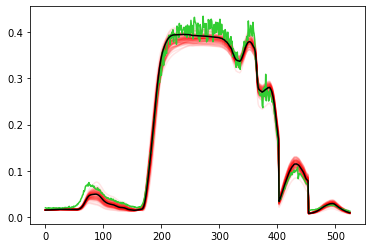

In [786]:


# plt.plot(prosail_model(n=1,cab=45,cbrown=.5,
#                        cw=.02,cm=.005,lai=4,
#                        lidfa=52,hspot=0,
#                        tts=70,tto=2,psi=220))

for i in np.random.randint(0, 1000, 75):
    sim = prosail_model(trace_lv["cab"][i],
                           trace_lv["cbrown"][i],
                           trace_lv["lai"][i],
                           trace_lv["cw"][i])
    plt.plot(sim, alpha=.1, c='r')

# plt.plot(prosail_model(n=.3,cab=41,cbrown=.1,
#                        lai=5.84, cw=.04), c='blue')



plt.plot(aerial_HSI['var_'].isel(col=41,row=18), c='limegreen', alpha=1)
plt.plot(prosail_model(*az.stats.summary(idata_lv)['mean']), c='k')

array([[<AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'n'}>],
       [<AxesSubplot:title={'center':'cab'}>,
        <AxesSubplot:title={'center':'cab'}>],
       [<AxesSubplot:title={'center':'cbrown'}>,
        <AxesSubplot:title={'center':'cbrown'}>],
       [<AxesSubplot:title={'center':'cw'}>,
        <AxesSubplot:title={'center':'cw'}>],
       [<AxesSubplot:title={'center':'cm'}>,
        <AxesSubplot:title={'center':'cm'}>]], dtype=object)

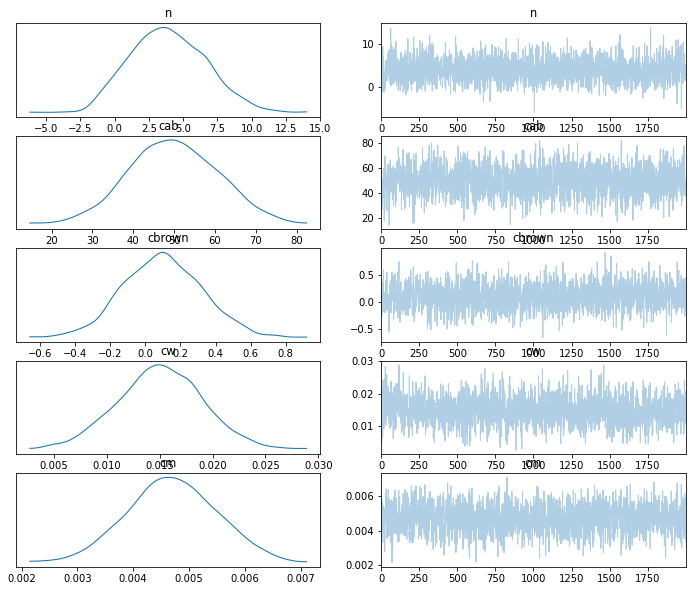

In [144]:
az.plot_trace(idata_lv)

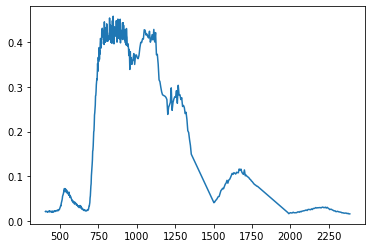

In [88]:
plt.plot(aerial_HSI['wvl_center'], aerial_HSI['var_'].isel(col=20,row=20))

In [101]:
aerial_HSI['wvl_center']

<xarray.DataArray 'wvl_center' (bands: 526)>
array([ 405.358166,  407.048711,  408.739255, ..., 2375.27881 , 2380.947955,
       2386.6171  ])
Dimensions without coordinates: bands

In [81]:
field_data.columns

Index(['PlotNum', 'Xutm', 'Yutm', 'Xpix', 'Ypix', 'Crop', 'LAI', 'Cab',
       'Vcmax25_time', 'Vcmax25', 'NPQ1_time', 'NPQ1', 'NPQ2_time', 'NPQ2',
       'ceptometer_time', 'PARin', 'PARbottom', 'PARrefl_top', 'PARrefl_soil',
       'aPAR', 'faPAR'],
      dtype='object')

# VCmax
- use chlorophyll map as feature
- use temperature and V

Text(0.5, 1.0, 'Vcmax25')

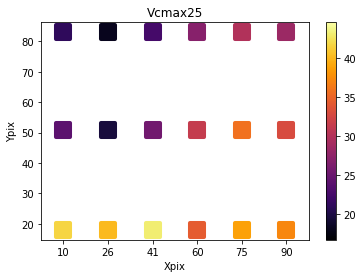

In [22]:
cvar = 'Vcmax25'
ax = seaborn.pointplot(data=field_data, x='Xpix', y='Ypix',
                       hue=cvar, palette='inferno', markers='s',scale=2)

norm = plt.Normalize(field_data[cvar].min(), field_data[cvar].max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
ax.set_title(cvar)

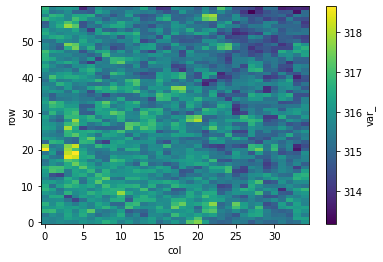

In [23]:
aerial_LST['var_'][:, 5:40,20:80].T.plot()

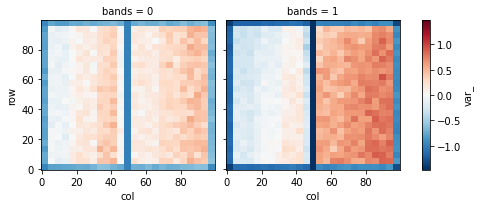

In [24]:
(aerial_F['var_'] - aerial_F['var_'].mean(['row','col'])).T.plot(col='bands')

In [ ]:
_X = pca_1[get_pix_n(field_data['Xpix'], field_data['Ypix']), :]
_y = field_data['Cab']
plt.scatter(_y,GPR_cab.predict(_X) * 10)
plt.errorbar(_y,GPR_cab.predict(_X) * 10,GPR_cab.predict(_X, return_std=True)[1] * 10,fmt='none')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.plot(np.linspace(35,62),np.linspace(35,62))
seaborn.despine()

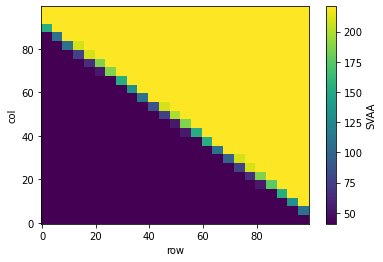

In [25]:
aerial_F['SVAA'].plot()

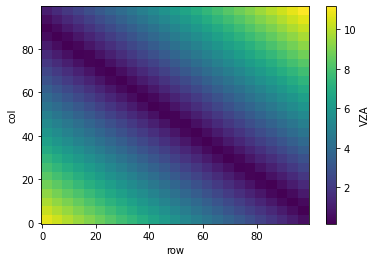

In [26]:
aerial_F['VZA'].plot()